In [1]:
import pandas as pd
import yfinance as yf
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler

BTC-USD
Bin Thresholds:  [-10, -0.2667088690944112, 0.588007409823948, 10]


<AxesSubplot:>

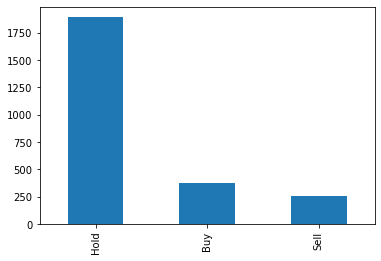

In [20]:
def generate_features(ticker, period_range="Max", buy_sell_threshold =[0.1,0.85]):
    stk_data = yf.Ticker(ticker)
    print(stk_data.ticker)
    df_data = stk_data.history(period=period_range)


    df_data['Week'] = df_data.index.isocalendar().week
    df_data['Day'] = df_data.index.isocalendar().day

    df_data['PrevDayChng'] = df_data['Close'].pct_change(periods=1).shift(1).fillna(0)
    df_data['Var'] = df_data.Close.rolling(10).var()
    df_data['Var'] = df_data['Var'].fillna(df_data['Var'].mean())

    df_data['52Wk_High'] = df_data.Close.rolling(250, min_periods=1).max()
    df_data['52Wk_Low'] = df_data.Close.rolling(250, min_periods=1).min()

    df_data['EMA5'] = df_data.Close.ewm(span=5, adjust=False).mean()
    df_data['EMA12'] = df_data.Close.ewm(span=12, adjust=False).mean()
    df_data['EMA26'] = df_data.Close.ewm(span=26, adjust=False).mean()
    df_data['MACD'] = df_data.EMA12-df_data.EMA26
    df_data['Signal'] = df_data.MACD.ewm(span=9, adjust=False).mean()
    df_data['MACD_Trigger'] = df_data.MACD - df_data.Signal

    # % Change in 2 weeks
    df_data['Short_Gain'] = df_data.Close.pct_change(10).shift(-10)
    df_data['Short_Gain'] = df_data['Short_Gain'].fillna(df_data['Short_Gain'].mean())

    # % change in 3 months
    df_data['Long_Gain'] = df_data.Close.pct_change(60).shift(-60)
    df_data['Long_Gain'] = df_data['Long_Gain'].fillna(df_data['Long_Gain'].mean())

    bins=[-10]+list(df_data.Long_Gain.quantile(buy_sell_threshold))+[10]
    print("Bin Thresholds: ", bins)
    df_data['Rating'] = pd.cut(df_data.Long_Gain, bins=bins, labels=['Sell', 'Hold', 'Buy',])

    return df_data

df_data = generate_features('F')
df_data

df_data.Rating.value_counts().plot(kind='bar')


<AxesSubplot:xlabel='Date', ylabel='Close'>

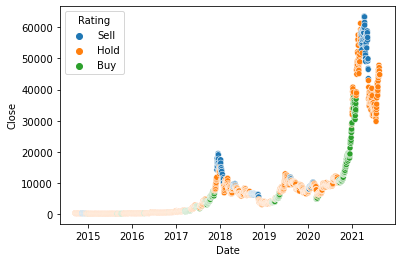

In [21]:
sns.scatterplot(data=df_data, x=df_data.index, y='Close', hue='Rating')

In [4]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7191 entries, 1993-01-29 to 2021-08-18
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Open          7191 non-null   float64 
 1   High          7191 non-null   float64 
 2   Low           7191 non-null   float64 
 3   Close         7191 non-null   float64 
 4   Volume        7191 non-null   int64   
 5   Dividends     7191 non-null   float64 
 6   Stock Splits  7191 non-null   int64   
 7   Week          7191 non-null   UInt32  
 8   Day           7191 non-null   UInt32  
 9   PrevDayChng   7191 non-null   float64 
 10  Var           7191 non-null   float64 
 11  52Wk_High     7191 non-null   float64 
 12  52Wk_Low      7191 non-null   float64 
 13  EMA5          7191 non-null   float64 
 14  EMA12         7191 non-null   float64 
 15  EMA26         7191 non-null   float64 
 16  MACD          7191 non-null   float64 
 17  Signal        7191 non-null   floa

In [5]:
def transform_data(df_data):
    price_scaler = MinMaxScaler()
    df_data_scaled = df_data
    #Scale $$ Values
    df_data_scaled[['Close']] = price_scaler.fit_transform(df_data_scaled[['Close']])
    for c in ['Open', 'High', 'Low', '52Wk_High', '52Wk_Low']:
        df_data_scaled[[c]] = price_scaler.transform(df_data_scaled[[c]])
    #Scale Indicators
    indicator_cols =['Volume', 'Week', 'Day', 'PrevDayChng', 'MACD', 'Signal', 'EMA5', 'EMA12', 'EMA26', 'Var']
    indicator_scaler = MinMaxScaler()
    df_data_scaled[indicator_cols] = indicator_scaler.fit_transform(df_data_scaled[indicator_cols])
    #Scale %
    gain_cols = ['Short_Gain', 'Long_Gain']
    gain_scaler = MinMaxScaler()
    df_data_scaled[gain_cols] = gain_scaler.fit_transform(df_data_scaled[gain_cols])

    df_data_scaled = pd.get_dummies(df_data_scaled, columns=['Rating'])

    return df_data_scaled

df_data_scaled = transform_data(df_data)
df_data_scaled

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Week,Day,PrevDayChng,...,EMA12,EMA26,MACD,Signal,MACD_Trigger,Short_Gain,Long_Gain,Rating_Sell,Rating_Hold,Rating_Buy
Date,,,,,,,,,,,,,,,,,,,,,
1993-01-29,0.000784,0.000784,0.000479,0.000740,0.001146,0.0,0,0.057692,1.00,0.429751,...,0.000000,0.000000,0.717638,0.716671,0.000000,0.584545,0.511594,0,1,0
1993-02-01,0.000784,0.001175,0.000784,0.001175,0.000546,0.0,0,0.076923,0.00,0.429751,...,0.000068,0.000033,0.718094,0.716780,0.011711,0.517137,0.500189,0,1,0
1993-02-02,0.001132,0.001350,0.001001,0.001306,0.000225,0.0,0,0.076923,0.25,0.457685,...,0.000145,0.000073,0.718584,0.716984,0.021923,0.511384,0.502847,0,1,0
1993-02-03,0.001393,0.002003,0.001350,0.001959,0.000602,0.0,0,0.076923,0.50,0.438071,...,0.000312,0.000160,0.719642,0.717400,0.044664,0.488749,0.491682,0,1,0
1993-02-04,0.002177,0.002351,0.001480,0.002220,0.000604,0.0,0,0.076923,0.75,0.471268,...,0.000494,0.000260,0.720722,0.717990,0.063423,0.487583,0.494364,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-12,0.992052,0.995943,0.989774,0.995587,0.044665,0.0,0,0.596154,0.75,0.439510,...,0.996002,0.996060,0.830260,0.847467,0.096433,0.562895,0.540454,0,1,0
2021-08-13,0.996726,0.997556,0.995492,0.997509,0.045215,0.0,0,0.596154,1.00,0.441521,...,0.997705,0.997534,0.833409,0.848937,0.157918,0.562895,0.540454,0,1,0
2021-08-16,0.994211,1.000332,0.990272,1.000000,0.084653,0.0,0,0.615385,0.00,0.436898,...,0.999534,0.999087,0.837171,0.851010,0.222792,0.562895,0.540454,0,1,0


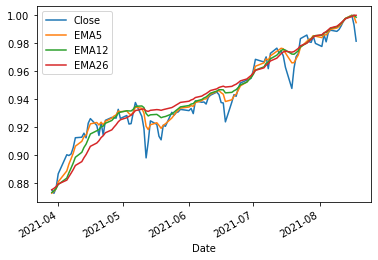

In [6]:
prices_sc = df_data_scaled.Close[-100:]
prices_sc.plot()
df_data_scaled.EMA5[-100:].plot()
df_data_scaled.EMA12[-100:].plot()
df_data_scaled.EMA26[-100:].plot()
plt.legend()

In [18]:
def part_data(df_data_scaled, test_size = 200):
    df_X_input = df_data_scaled.copy().drop(columns=['Short_Gain', 'Long_Gain', 'Rating_Sell', 'Rating_Hold', 'Rating_Buy'])
    X_train = df_X_input[:-test_size].values
    X_test = df_X_input[-test_size:].values

    df_y_input = df_data_scaled[['Rating_Sell', 'Rating_Hold', 'Rating_Buy']]
    y_train = df_y_input[:-test_size].values
    y_test = df_y_input[-test_size:].values

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = part_data(df_data_scaled)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6991, 19) (200, 19) (6991, 3) (200, 3)


In [19]:
from keras.layers import Input, Concatenate, Dense
from keras.models import Model
input_tensor = Input(shape=(1,))
output_tensor = Dense(2)(input_tensor)
